In [2]:
import pandas as pd
import os
from nltk.tokenize import RegexpTokenizer
import ast
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.pipeline import make_pipeline
import matplotlib.patches as mpatches
import matplotlib
from sklearn.decomposition import PCA, TruncatedSVD
import random
from collections import defaultdict


import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

import gensim

from lime import lime_text
from lime.lime_text import LimeTextExplainer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.layers import Dense, Input, Flatten, Dropout, Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

pd.set_option("display.max_colwidth", 80)

%matplotlib inline

In [3]:
word2vec_path = "~/data/reference/GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [4]:
df_trn = pd.read_csv("/home/ubuntu/data/cleaned/disaster_response_messages_training.csv", dtype={"split": str, "message": str, "original": str, "genre": str})
df_trn["tokens"] = df_trn["tokens"].apply(ast.literal_eval)
df_trn = df_trn.sample(frac=1.0, random_state=42)
df_trn.head(40)

,Unnamed: 0,id,split,message,original,genre,related,PII,request,offer,...,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,message_std,tokens
16944,16944,24527,train,This week the government launched a 100-million-dollar climate resilience pr...,NaN,news,1,0,0,0,...,0,0,0,0,0,0,0,0,this week the government launched a 100 million dollar climate resilience pr...,"[this, week, the, government, launched, a, 100, million, dollar, climate, re..."
20803,20803,29923,train,"Whatever the political calculations in Jakarta, disgruntled residents here b...",NaN,news,1,0,1,0,...,0,0,0,0,0,0,0,1,"whatever the political calculations in jakarta, disgruntled residents here b...","[whatever, the, political, calculations, in, jakarta, disgruntled, residents..."
6836,6836,9512,train,Bases insolubles Cu(OH)2-Fe(OH)3-Cr(OH)2-CuOH-Zn(OH)2-Al(OH)3-Pb(OH)2 Base I...,Bases insolubles Cu ( OH ) 2-Fe ( OH ) 3-Cr ( OH ) 2-CuOH-Zn ( OH ) 2-Al ( O...,direct,0,0,0,0,...,0,0,0,0,0,0,0,0,bases insolubles cu(oh)2 fe(oh)3 cr(oh)2 cuoh zn(oh)2 al(oh)3 pb(oh)2 base i...,"[bases, insolubles, cu, oh, 2, fe, oh, 3, cr, oh, 2, cuoh, zn, oh, 2, al, oh..."
5865,5865,8227,train,I want to get contact with an Organisation (ONG) to let it know that I have ...,Mwen bezwen antre an kontak ak 0NG paske m gen anpil problem ak moun ki mala...,direct,1,0,1,0,...,0,0,0,0,0,0,0,1,i want to get contact with an organisation (ong) to let it know that i have ...,"[i, want, to, get, contact, with, an, organisation, ong, to, let, it, know, ..."
7628,7628,10665,train,"The SMS: Hello at you operators, I will ask you for information. Is there wo...","Bonjour vous operateurs,je vais vous demander une information.Est qu'il aur...",direct,1,0,0,0,...,0,0,0,0,0,0,0,0,"the sms hello at you operators, i will ask you for information is there wo...","[the, sms, hello, at, you, operators, i, will, ask, you, for, information, i..."
11968,11968,17622,train,The China Meteorological Administration issued a red alert early that day fo...,NaN,news,1,0,0,0,...,0,0,0,0,0,0,0,0,the china meteorological administration issued a red alert early that day fo...,"[the, china, meteorological, administration, issued, a, red, alert, early, t..."
11062,11062,16382,train,"In the Philippines, millions of terrified flood survivors, many of them shel...",NaN,news,1,0,0,0,...,1,1,1,0,0,0,0,0,"in the philippines, millions of terrified flood survivors, many of them shel...","[in, the, philippines, millions, of, terrified, flood, survivors, many, of, ..."
6024,6024,8431,train,"If I have diarrhe what can I do,I am a survivor",Si m gen kolerin kisa pou m fe m se yon riskape,direct,1,0,1,0,...,0,0,0,0,0,0,0,1,"if i have diarrhe what can i do,i am a survivor","[if, i, have, diarrhe, what, can, i, do, i, am, a, survivor]"
11216,11216,16587,train,The engineers have trained thousands of people to build and design their hou...,NaN,news,1,0,0,0,...,0,0,0,0,0,0,0,0,the engineers have trained thousands of people to build and design their hou...,"[the, engineers, have, trained, thousands, of, people, to, build, and, desig..."
17064,17064,24686,train,Assessment missions by government authorities were conducted in extremely di...,NaN,news,0,0,0,0,...,0,0,0,0,0,0,0,0,assessment missions by government authorities were conducted in extremely di...,"[assessment, missions, by, government, authorities, were, conducted, in, ext..."


In [5]:
df_val = pd.read_csv("/home/ubuntu/data/cleaned/disaster_response_messages_validation.csv", dtype={"split": str, "message": str, "original": str, "genre": str})
df_val["tokens"] = df_val["tokens"].apply(ast.literal_eval)
df_val.head()

,Unnamed: 0,id,split,message,original,genre,related,PII,request,offer,...,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,message_std,tokens
0,0,8,validation,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ak timoun yo. Mesi se john jea...",direct,1,0,0,0,...,0,0,0,0,0,0,0,0,looking for someone but no name,"[looking, for, someone, but, no, name]"
1,1,18,validation,I am in Croix-des-Bouquets. We have health issues. They ( workers ) are in S...,"Nou kwadebouke, nou gen pwoblem sant m yo nan santo 15",direct,1,0,1,0,...,0,0,0,0,0,0,0,1,i am in croix des bouquets we have health issues they ( workers ) are in s...,"[i, am, in, croix, des, bouquets, we, have, health, issues, they, workers, a..."
2,2,28,validation,are you going to call me or do you want me to call ou? let me know?,Eske se rele nap relem oubyen se mwen kap rele nou?si se mwen eske,direct,0,0,0,0,...,0,0,0,0,0,0,0,0,are you going to call me or do you want me to call ou? let me know?,"[are, you, going, to, call, me, or, do, you, want, me, to, call, ou, let, me..."
3,3,38,validation,"People I'm at Delma 2, we don't anything what so ever, please provide us wit...",MEZANMI MWEN MWEN NAN DELMA 2 NOU TR MAN MAL NOU PA JAN M JWEN ANY,direct,1,0,1,0,...,0,0,0,0,0,0,0,1,"people i'm at delma 2, we don't anything what so ever, please provide us wit...","[people, i, m, at, delma, 2, we, don, t, anything, what, so, ever, please, p..."
4,4,48,validation,"How we can find food and water? we have people in many differents needs, and...",Comment nou ka jwen dlo ak manje nou gen moun ki gen tout kalte pwoblem nan ...,direct,1,0,0,0,...,0,0,0,0,0,0,0,0,"how we can find food and water? we have people in many differents needs, and...","[how, we, can, find, food, and, water, we, have, people, in, many, different..."


In [9]:
all_words = [word for tokens in df_trn["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df_trn["tokens"]]
VOCAB = sorted(list(set(all_words)))

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(VOCAB)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(df_trn["message_std"].tolist())
trn_sequences = tokenizer.texts_to_sequences(df_trn["message_std"].tolist())
val_sequences = tokenizer.texts_to_sequences(df_val["message_std"].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

trn_cnn_data = pad_sequences(trn_sequences, maxlen=MAX_SEQUENCE_LENGTH)
trn_labels = to_categorical(np.asarray(df_trn["related"]))

val_cnn_data = pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
val_labels = to_categorical(np.asarray(df_val["related"]))

trn_indices = np.arange(trn_cnn_data.shape[0])
np.random.seed(42)
np.random.shuffle(trn_indices)
trn_cnn_data = trn_cnn_data[trn_indices]
trn_labels = trn_labels[trn_indices]

#num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

Found 30984 unique tokens.
(30985, 300)


In [10]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

In [12]:
x_train = trn_cnn_data
y_train = trn_labels
x_val = val_cnn_data
y_val = val_labels

model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                len(list(df_trn["related"].unique())), False)

In [13]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=128)

Epoch 1/3
165/165 [==============================] - 17s 101ms/step - loss: 0.4906 - acc: 0.7808 - val_loss: 0.4083 - val_acc: 0.8208
Epoch 2/3
165/165 [==============================] - 17s 102ms/step - loss: 0.3904 - acc: 0.8269 - val_loss: 0.4010 - val_acc: 0.8185
Epoch 3/3
165/165 [==============================] - 17s 101ms/step - loss: 0.3531 - acc: 0.8467 - val_loss: 0.4104 - val_acc: 0.8255


In [21]:
y_val_pred = model.predict(x_val)

In [23]:
def get_metrics(y_truth, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_truth, y_predicted, pos_label=None, average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_truth, y_predicted, pos_label=None, average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_truth, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_truth, y_predicted)
    return accuracy, precision, recall, f1

#accuracy, precision, recall, f1 = get_metrics(y_val, y_val_pred)
#print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

In [28]:
y_val_ind = [np.argmax(y_val[i]) for i in range(2573)]
y_val_pred_ind = [np.argmax(y_val_pred[i]) for i in range(2573)]

In [29]:
accuracy, precision, recall, f1 = get_metrics(y_val_ind, y_val_pred_ind)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.825, precision = 0.815, recall = 0.825, f1 = 0.814


In [30]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

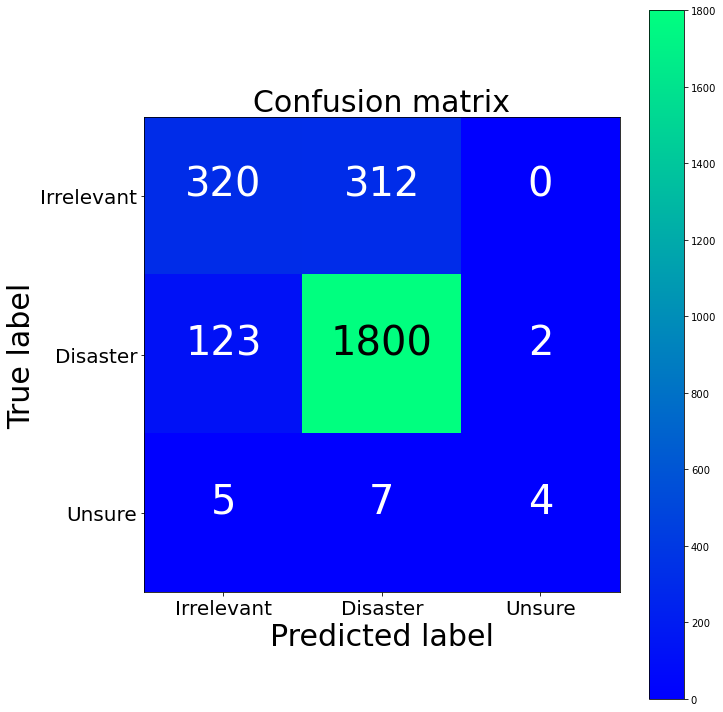

[[ 320  312    0]
 [ 123 1800    2]
 [   5    7    4]]


In [31]:
cm = confusion_matrix(y_val_ind, y_val_pred_ind)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

In [32]:
x_val.shape

(2573, 35)